In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import glob
%cd ../

/mnt/c/Users/Daniel Yang/Desktop/Final_Project


In [2]:
fileId_path = "experiments/fileIds.pkl"
queryInfo_path = "experiments/queryInfo.pkl"
timeData_path = "experiments/timeData.pkl"
audioFiles_path = "experiments/audioFiles.pkl"
with open(fileId_path, 'rb') as f:
    fileIds=pkl.load(f)
with open(queryInfo_path, 'rb') as f:
    queryInfo=pkl.load(f)
with open(timeData_path, 'rb') as f:
    timeData=pkl.load(f)
with open(audioFiles_path, 'rb') as f:
    audioFiles=pkl.load(f)

In [3]:
def readHypFiles(hypdir):
    
    for hypfile in sorted(glob.glob("{}/*.hyp".format(hypdir))):
        print(hypfile)
        with open(hypfile, "rb") as f:
            yield(pkl.load(f))

In [4]:
def evaluateBeatLevel(tf, solo_name, ref_name, sr=22050):
    # Only evaluate within segments
    diffs = []
    pieceName = solo_name.split('_')[0]
    gt_segments = queryInfo[pieceName]
    annotated_beats = list(timeData[ref_name].keys())
    for idx,beats in enumerate(gt_segments):
        beat1 = beats.split(',')[0][1:]
        beat2 = beats.split(',')[1][:-1]
        idx1 = annotated_beats.index(beat1)
        idx2 = annotated_beats.index(beat2)
        #offset = int(timeData[ref_name][beat1]*sr)-segment_predict[idx][0]
        #base_time = tf[segment_predict[idx][0]]
        base_time = tf[int(timeData[ref_name][beat1]*sr)]
        #print(offset)
        
        new_times = {}
        for i in range(idx1,idx2+1):
            key = annotated_beats[i]
            sample = tf[int(timeData[ref_name][key]*sr)]
            new_time = sample-base_time
            new_times[key]=new_time
            
        gt_beats = list(timeData[solo_name].keys())
        gt_base_time=timeData[solo_name][beat1]
        prev = 0
        prevgt = 0
        for idx, key in enumerate(new_times):
            if key in gt_beats:
                gt_time = (timeData[solo_name][key]-gt_base_time)*sr
                pred_time = new_times[key]
                #f idx != 0:
                #   print("diff",gt_time-prevgt, pred_time-prev)
                prev = pred_time
                prevgt = gt_time
                #rint(gt_time, pred_time)
                diffs.append(np.abs(gt_time-pred_time))
    return diffs

In [5]:
def evaluateBeatLevelFirst(tf, segment_predict, solo_name, ref_name, sr=22050):
    # Only evaluate within segments
    diffs = []
    pieceName = solo_name.split('_')[0]
    gt_segments = queryInfo[pieceName]
    annotated_beats = list(timeData[ref_name].keys())
    for idx,beats in enumerate(gt_segments):
        if idx!=1:
            continue
        beat1 = beats.split(',')[0][1:]
        beat2 = beats.split(',')[1][:-1]
        idx1 = annotated_beats.index(beat1)
        idx2 = annotated_beats.index(beat2)
        offset = int(timeData[ref_name][beat1]*sr)-segment_predict[idx][0]
        base_time = tf[segment_predict[idx][0]]
        
        new_times = {}
        for i in range(idx1,idx2+1):
            key = annotated_beats[i]
            sample = tf[int(timeData[ref_name][key]*sr)]
            new_time = sample-base_time
            new_times[key]=new_time
            
        gt_beats = list(timeData[solo_name].keys())
        gt_base_time=timeData[solo_name][beat1]
        prev = 0
        prevgt = 0
        for idx, key in enumerate(new_times):
            if key in gt_beats:
                gt_time = (timeData[solo_name][key]-gt_base_time)*sr
                pred_time = new_times[key]
                #f idx != 0:
                #   print("diff",gt_time-prevgt, pred_time-prev)
                prev = pred_time
                prevgt = gt_time
                #rint(gt_time, pred_time)
                diffs.append(np.abs(gt_time-pred_time))
    return diffs

In [6]:
def evaluateSegmentLevel(segment_predict, solo_name, ref_name, sr=22050):
    pieceName = solo_name.split('_')[0]
    gt_segments = queryInfo[pieceName]
    gt_samples = []
    diffs = []
    for beats in gt_segments:
        beat1 = beats.split(',')[0][1:]
        beat2 = beats.split(',')[1][:-1]
        sample1 = timeData[ref_name][beat1]*sr
        sample2 = timeData[ref_name][beat2]*sr
        gt_samples.append((sample1, sample2))
    for idx,segment in enumerate(segment_predict):
        seg0 = segment[0]
        seg1 = segment[1]
        diff0 = np.abs(gt_samples[idx][0]-seg0)
        diff1 = np.abs(gt_samples[idx][1]-seg1)
        diffs.append(diff0)
        diffs.append(diff1)
        if diff0 > 22050:
            print(solo_name, ref_name)
            print(gt_samples[idx][0],seg0)
        if diff1 > 22050:
            print(ref_name, solo_name)
            print(gt_samples[idx][1],seg1)
        #print((gt_samples[idx][0]-seg0)/(sr*sr))
    return diffs, gt_samples, segment_predict

In [7]:
def evaluate(hypdir, hop_length=512, sr=22050):
    
    times = []
    segment_tolerances =[1, 0.5, 0.25]
    segment_total = np.zeros(len(segment_tolerances))
    segment_correct = np.zeros(len(segment_tolerances))
    
    beat_tolerances =np.arange(0.0, 2, 0.025)
    #beat_tolerances=[0.25]
    beat_total = np.zeros(len(beat_tolerances))
    beat_correct = np.zeros(len(beat_tolerances))
    beat_totalFirst = np.zeros(len(beat_tolerances))
    beat_correctFirst = np.zeros(len(beat_tolerances))
    for solo_name, ref_name, tf, segment_predict, time_taken in readHypFiles(hypdir):
        tf = np.array(tf)
        segment_predict = np.array(segment_predict)*hop_length
        #print(segment_predict)
        segment_diffs, gt_samples, segment_predict = evaluateSegmentLevel(segment_predict, solo_name, ref_name)
        if any(tf!=None):
            beat_diffs = evaluateBeatLevel(tf, solo_name, ref_name)
            beat_diffsFirst = evaluateBeatLevelFirst(tf, segment_predict, solo_name, ref_name)
            #beat_diffs = evaluateDiffLevel(tf, segment_predict, solo_name, ref_name)
            beat_diffs =(np.array(beat_diffs)/sr)
            beat_diffsFirst =(np.array(beat_diffsFirst)/sr)
        segment_diffs =np.array(segment_diffs)/sr
        times.append(time_taken)
        
        #Update Segment Level Accuracy
        for idx, tolerance in enumerate(segment_tolerances):
            segment_correct[idx] += np.sum(np.where(segment_diffs<tolerance, 1, 0))
            segment_total[idx]+=len(segment_diffs)
            
            
        if any(tf!=None):
            #Update Beat Level Accuracy
            for idx, tolerance in enumerate(beat_tolerances):
                beat_correct[idx] += np.sum(np.where(beat_diffs<tolerance, 1, 0))
                beat_total[idx]+=len(beat_diffs)

            #Update First Beat Level Accuracy
            for idx, tolerance in enumerate(beat_tolerances):
                beat_correctFirst[idx] += np.sum(np.where(beat_diffsFirst<tolerance, 1, 0))
                beat_totalFirst[idx]+=len(beat_diffsFirst)
    print("hop_length", hop_length)
    print(segment_correct/segment_total)
    print(beat_correct/beat_total)
    return segment_correct/segment_total, beat_correct/beat_total, times   

In [8]:
seg_accuracy, beat_accuracy, times = evaluate("experiments/expFinal", hop_length=512)
#seg_accuracy, beat_accuracy = evaluate("baselines/debug2")

experiments/expFinal/p1s_perf12-p1f_perf16.hyp
experiments/expFinal/p1s_perf12-p1f_perf2.hyp
p1f_perf2 p1s_perf12
3928012.66666305 3983360
experiments/expFinal/p1s_perf12-p1f_perf23.hyp
p1f_perf23 p1s_perf12
3797529.00000075 3849216
experiments/expFinal/p1s_perf12-p1f_perf24.hyp
experiments/expFinal/p1s_perf12-p1f_perf6.hyp
p1f_perf6 p1s_perf12
3799099.9999963506 3838976
experiments/expFinal/p1s_perf2-p1f_perf16.hyp
experiments/expFinal/p1s_perf2-p1f_perf2.hyp
experiments/expFinal/p1s_perf2-p1f_perf23.hyp
experiments/expFinal/p1s_perf2-p1f_perf24.hyp
experiments/expFinal/p1s_perf2-p1f_perf6.hyp
experiments/expFinal/p1s_perf25-p1f_perf16.hyp
p1f_perf16 p1s_perf25
3888554.6666641505 3974144
experiments/expFinal/p1s_perf25-p1f_perf2.hyp
p1f_perf2 p1s_perf25
3928012.66666305 4083712
experiments/expFinal/p1s_perf25-p1f_perf23.hyp
p1f_perf23 p1s_perf25
3797529.00000075 3882496
experiments/expFinal/p1s_perf25-p1f_perf24.hyp
p1f_perf24 p1s_perf25
3493643.6666648993 3522560
p1f_perf24 p1s_perf2

/home/dyang/anaconda3/envs/MIR5/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less


experiments/expFinal/p2s_perf17-p2f_perf14.hyp
experiments/expFinal/p2s_perf17-p2f_perf18.hyp
p2f_perf18 p2s_perf17
1304883.6666684 1280000
p2f_perf18 p2s_perf17
5317967.9999963995 5291008
experiments/expFinal/p2s_perf17-p2f_perf20.hyp
experiments/expFinal/p2s_perf17-p2f_perf5.hyp
p2f_perf5 p2s_perf17
4821841.6666623 4788736
experiments/expFinal/p2s_perf4-p2f_perf1.hyp
p2f_perf1 p2s_perf4
1345851.3333310501 1297408
experiments/expFinal/p2s_perf4-p2f_perf14.hyp
experiments/expFinal/p2s_perf4-p2f_perf18.hyp
p2f_perf18 p2s_perf4
5317967.9999963995 5287424
experiments/expFinal/p2s_perf4-p2f_perf20.hyp
experiments/expFinal/p2s_perf4-p2f_perf5.hyp
p2f_perf5 p2s_perf4
3153074.3333375994 3209216
p2f_perf5 p2s_perf4
4821841.6666623 4794880
experiments/expFinal/p2s_perf8-p2f_perf1.hyp
p2f_perf1 p2s_perf8
1345851.3333310501 1321984
experiments/expFinal/p2s_perf8-p2f_perf14.hyp
p2f_perf14 p2s_perf8
5230606.3333377 5207040
experiments/expFinal/p2s_perf8-p2f_perf18.hyp
p2f_perf18 p2s_perf8
1304883.6

/home/dyang/anaconda3/envs/MIR5/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less


experiments/expFinal/p3s_perf22-p3f_perf16.hyp
experiments/expFinal/p3s_perf22-p3f_perf2.hyp
experiments/expFinal/p3s_perf22-p3f_perf23.hyp
experiments/expFinal/p3s_perf22-p3f_perf24.hyp
experiments/expFinal/p3s_perf9-p3f_perf11.hyp
experiments/expFinal/p3s_perf9-p3f_perf16.hyp
experiments/expFinal/p3s_perf9-p3f_perf2.hyp
p3s_perf9 p3f_perf2
3455676.3333372 3425280
experiments/expFinal/p3s_perf9-p3f_perf23.hyp
experiments/expFinal/p3s_perf9-p3f_perf24.hyp
experiments/expFinal/p4s_perf15-p4f_perf13.hyp
p4s_perf15 p4f_perf13
204395.33332680003 1395712
p4f_perf13 p4s_perf15
1369877.33333535 2529792
experiments/expFinal/p4s_perf15-p4f_perf16.hyp
p4s_perf15 p4f_perf16
18244.666661550003 1144832
p4f_perf16 p4s_perf15
1116649.33333275 2265088
experiments/expFinal/p4s_perf15-p4f_perf2.hyp
experiments/expFinal/p4s_perf2-p4f_perf13.hyp
p4s_perf2 p4f_perf13
204395.33332680003 1395200
p4f_perf13 p4s_perf2
1369877.33333535 2530304
experiments/expFinal/p4s_perf2-p4f_perf16.hyp
p4s_perf2 p4f_perf16
1

In [102]:
np.average(times)

7.503427006732458

Text(0, 0.5, 'Error')

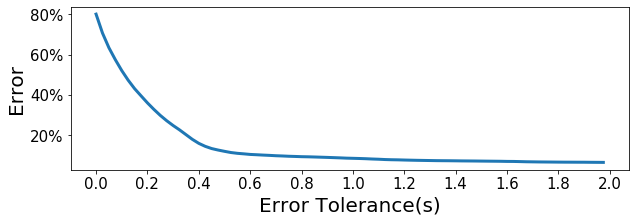

In [12]:
plt.figure(figsize=(10,3))
x=np.arange(0.0, 2, 0.025)
plt.rcParams.update({'font.size': 15})
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.plot(x, 1-np.array(beat_accuracy), linewidth=3)
plt.xticks(np.arange(min(x), max(x)+.1, 0.2))
plt.xlabel('Error Tolerance(s)', fontsize=20)
plt.ylabel('Error', fontsize=20)